# Leela Zerozeug

In [1]:
import sys
import os
import math

import numpy as np
import scipy.stats as stats

import sqlite3

from PIL import Image
from IPython import display
import matplotlib.pyplot as pyplot
%matplotlib inline

%load_ext autoreload
%autoreload 2

from src import *

In [2]:
# Leela Zero Training Match Database
db_path = 'data/leela-zero.db'

# Confidence Level for Hypothesis Tests
alpha = 0.01

## Resignation Rate

While scrutinising the *Leela Zero* web pages, I noticed what seemed like an alarmingly high resignation rate. How large, exactly?

75559 of 77808 games (97.1096%) ended with resignation.


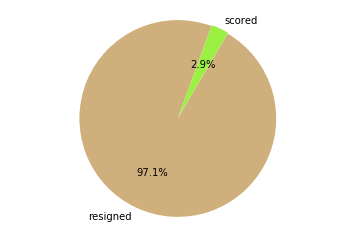

In [3]:
with sqlite3.connect(db_path) as sql:
    count_games = sql.execute("SELECT COUNT(*) FROM Game").fetchone()[0]
    count_resignations = sql.execute("SELECT COUNT(*) FROM Game WHERE resign=1").fetchone()[0]
    
print("{0} of {1} games ({2:.4%}) ended with resignation.".format(count_resignations, count_games, (count_resignations / count_games)))

pyplot.figure()
pyplot.pie([count_resignations, count_games - count_resignations],
           labels = ['resigned', 'scored'], colors = ['xkcd:fawn', 'xkcd:kiwi'], explode = (0.01, 0),
           autopct = '%1.1f%%', shadow=False, startangle=70)
pyplot.axis('equal')
pyplot.show()

Well. I wonder why so many match games end prematurely. These games are played *without* Dirichlet noise.

## Fairness Tests

Here is a routine to test fairness using a *coin-toss* model in which various trials are modelled as *independent* Bernoulli trials.

In [4]:
def test_fairness(trials, p, successes, alpha, silent=False):
    mu = trials * p
    sigma = math.sqrt(trials * p * (1.0 - p))
    delta = abs(mu - successes)
    p_binomial = 2.0 * stats.binom.cdf(mu - delta, trials, p) if (delta > 0) else 1.0
    p_normal = 2.0 * (1.0 - stats.norm.cdf((delta - 0.5) / sigma)) if (delta > 0) else 1.0
    reject = (p_binomial < alpha)
    
    if not silent:
        print("Expected number of successes after {0} Bernoulli trials (p = {1:.1%}): {2}".format(trials, p, mu))
        print("Observed successes after {0} Bernoulli trials: {1}".format(trials, successes))
        print("Probability of observing ≤ {0} or ≥ {1} successes: {2:.4%}    (binomial distribution)".format((mu - delta), (mu + delta), p_binomial))
        print("Probability of observing ≤ {0} or ≥ {1} successes: {2:.4%}    (normal approximation)".format((mu - delta), (mu + delta), p_normal))
        if reject:
            print("At an α = {0} confidence level, we REJECT the null hypothesis that p = {1}.".format(alpha, p))
        else:
            print("At an α = {0} confidence level, we have insufficient evidence to reject the null hypothesis that p = {1}.".format(alpha, p))
            
    return reject

As a sanity check, let's apply the test to the scraped data in the simplest way imaginable. It is immediately apparent that the *nigiri* procedure is, at least, unbiased.

<span style="color: red;">(For all following tests, unless otherwise stated, it is assumed that *nigiri* is fair and that the stronger and weaker networks get equal opportunities to play as both colours within the scope of a match.)</span>

In 38865 of 77808 games (49.9499%), the challenger took black.

Expected number of successes after 77808 Bernoulli trials (p = 50.0%): 38904.0
Observed successes after 77808 Bernoulli trials: 38865
Probability of observing ≤ 38865.0 or ≥ 38943.0 successes: 78.2514%    (binomial distribution)
Probability of observing ≤ 38865.0 or ≥ 38943.0 successes: 78.2514%    (normal approximation)
At an α = 0.01 confidence level, we have insufficient evidence to reject the null hypothesis that p = 0.5.


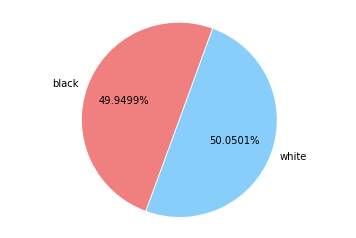

In [5]:
with sqlite3.connect(db_path) as sql:
    count_games = sql.execute("SELECT COUNT(*) FROM Game").fetchone()[0]
    count_challenger_as_black = sql.execute("SELECT COUNT(*) FROM Game"
                                            " JOIN Match ON Game.match_id = Match.id"
                                            " WHERE Game.black = Match.challenger").fetchone()[0]
    
print("In {0} of {1} games ({2:.4%}), the challenger took black.".format(count_challenger_as_black, count_games, (count_challenger_as_black / count_games)))
print()

test_fairness(count_games, 0.5, count_challenger_as_black, alpha)

pyplot.figure()
pyplot.pie([count_challenger_as_black, count_games - count_challenger_as_black],
           labels = ['black', 'white'], colors = ['lightcoral', 'lightskyblue'], explode = (0.01, 0),
           autopct = '%1.4f%%', shadow=False, startangle=70)
pyplot.axis('equal')
pyplot.show()

Now, let's test the assumption that *komi*, alone, makes the game of *Go* fair. Let's be naïeve and consider only global totals, weighting game results equally, regardless of the match in which they were played or the network that played them.

Black won 33782 games; white won 44026.

Expected number of successes after 77808 Bernoulli trials (p = 50.0%): 38904.0
Observed successes after 77808 Bernoulli trials: 33782
Probability of observing ≤ 33782.0 or ≥ 44026.0 successes: 0.0000%    (binomial distribution)
Probability of observing ≤ 33782.0 or ≥ 44026.0 successes: 0.0000%    (normal approximation)
At an α = 0.01 confidence level, we REJECT the null hypothesis that p = 0.5.


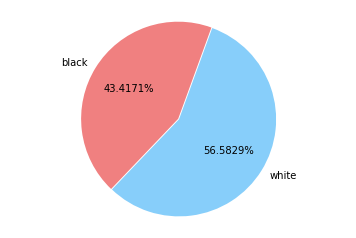

In [6]:
with sqlite3.connect(db_path) as sql:
    (black_victories, white_victories) = sql.execute("SELECT SUM(case [victor] when 1 then 1 else 0 end) as [black], SUM(case [victor] when 2 then 1 else 0 end) as [white] FROM Game").fetchone()
    
print("Black won {0} games; white won {1}.".format(black_victories, white_victories))
print()

test_fairness((black_victories + white_victories), 0.5, black_victories, alpha)

pyplot.figure()
pyplot.pie([black_victories, white_victories],
           labels = ['black', 'white'], colors = ['lightcoral', 'lightskyblue'], explode = (0.01, 0),
           autopct = '%1.4f%%', shadow=False, startangle=70)
pyplot.axis('equal')
pyplot.show()

That's interesting: white appears to be favoured and the margin appears to be statistically significant. Taken by itself, this result could be enough to conclude that *Leela Zero* prefers white although it gives no indication of *why* this might be the case. The model used and the data-selection criteria are extremely naïeve, however -- we need to go deeper!

### Fairness Tests: Matches

Let's restrict the query to the thirty most recent, completed matches -- about 30% of the available data -- and also repeat the hypothesis test for each match, independently.

In [7]:
def present_match_black_white_win_rate(query, title, history = 30):
    match_count = 0
    match_black_victories = []
    match_white_victories = []
    match_dates = []
    match_rejects = []
    total_black_victories = 0
    total_white_victories = 0
    black_rejects = 0
    white_rejects = 0

    with sqlite3.connect(db_path) as sql:
        cursor = sql.execute(query + " LIMIT ?", [history])

        for r in cursor:
            (match_id, start_date, black_victories, white_victories) = r
            total_black_victories += black_victories
            total_white_victories += white_victories

            reject = test_fairness((black_victories + white_victories), 0.5, black_victories, alpha, silent=True)
            if (reject) and (black_victories > white_victories):
                black_rejects = black_rejects + 1
            elif (reject) and (white_victories > black_victories):
                white_rejects = white_rejects + 1

            match_count = match_count + 1
            match_black_victories.append(black_victories)
            match_white_victories.append(white_victories)
            match_dates.append(start_date)
            match_rejects.append((max(black_victories, white_victories) + 10) if reject else None)

    print("Black won {0} games; white won {1}.".format(total_black_victories, total_white_victories))
    print()

    test_fairness((total_black_victories + total_white_victories), 0.5, total_black_victories, alpha)

    pyplot.figure()
    pyplot.pie([total_black_victories, total_white_victories],
               labels = ['black', 'white'], colors = ['lightcoral', 'lightskyblue'], explode = (0.01, 0),
               autopct = '%1.4f%%', shadow=False, startangle=70)
    pyplot.axis('equal')
    pyplot.show()

    match_index = np.arange(match_count)

    pyplot.figure(figsize=(12, 6))
    pyplot.bar(match_index, match_black_victories, 0.4, color='lightcoral', label='black')
    pyplot.bar(match_index + 0.4, match_white_victories, 0.4, color='lightskyblue', label='white')
    pyplot.scatter(match_index + 0.2, match_rejects, marker='x', color='red')

    pyplot.suptitle('Black-White Win-Rates')
    pyplot.title(title.format(history))
    pyplot.ylabel('victories')
    pyplot.xticks(match_index + 0.2, match_dates, rotation=90)
    pyplot.legend(bbox_to_anchor=(1.11, 1.0), loc='upper right', borderaxespad=0)
    pyplot.show()

    print()
    print("Data from {0} of {1} recent matches proved sufficient to reject the null hypothesis at α = {2}.".format(sum(r is not None for r in match_rejects), len(match_rejects), alpha))
    print("{0} of these matches favoured black; {1} of these favoured white.".format(black_rejects, white_rejects))

Black won 4230 games; white won 5791.

Expected number of successes after 10021 Bernoulli trials (p = 50.0%): 5010.5
Observed successes after 10021 Bernoulli trials: 4230
Probability of observing ≤ 4230.0 or ≥ 5791.0 successes: 0.0000%    (binomial distribution)
Probability of observing ≤ 4230.0 or ≥ 5791.0 successes: 0.0000%    (normal approximation)
At an α = 0.01 confidence level, we REJECT the null hypothesis that p = 0.5.


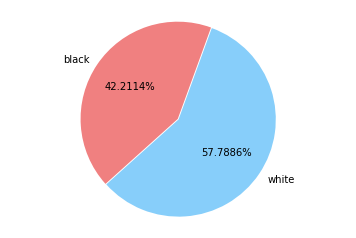

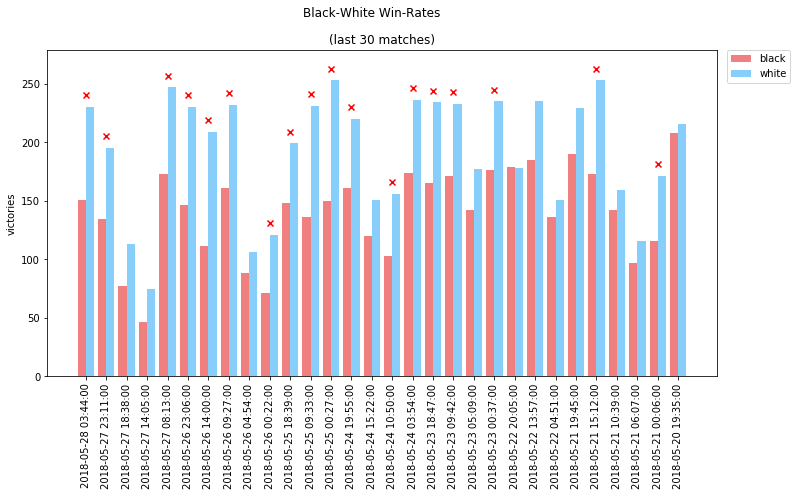


Data from 18 of 30 recent matches proved sufficient to reject the null hypothesis at α = 0.01.
0 of these matches favoured black; 18 of these favoured white.


In [8]:
query = """
SELECT Game.match_id, Match.start_date, SUM(case [victor] when 1 then 1 else 0 end) as [black], SUM(case [victor] when 2 then 1 else 0 end) as [white]
 FROM Game
 JOIN Match ON Game.match_id = Match.id
 WHERE Match.result is not null
 GROUP BY Game.match_id, Match.start_date
 ORDER BY Match.start_date DESC
"""
present_match_black_white_win_rate(query, '(last {0} matches)')

Black won 4742 games; white won 6444.

Expected number of successes after 11186 Bernoulli trials (p = 50.0%): 5593.0
Observed successes after 11186 Bernoulli trials: 4742
Probability of observing ≤ 4742.0 or ≥ 6444.0 successes: 0.0000%    (binomial distribution)
Probability of observing ≤ 4742.0 or ≥ 6444.0 successes: 0.0000%    (normal approximation)
At an α = 0.01 confidence level, we REJECT the null hypothesis that p = 0.5.


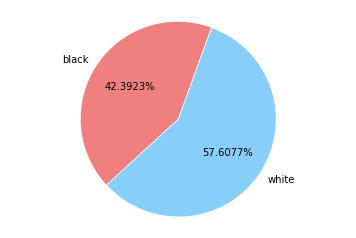

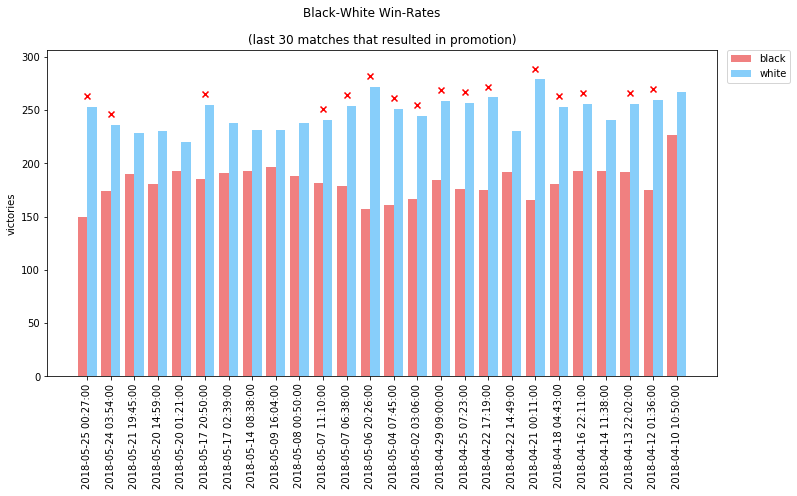


Data from 16 of 26 recent matches proved sufficient to reject the null hypothesis at α = 0.01.
0 of these matches favoured black; 16 of these favoured white.


In [9]:
query = """
SELECT Game.match_id, start_date, SUM(case Game.victor when 1 then 1 else 0 end) as [black], SUM(case Game.victor when 2 then 1 else 0 end) as [white]
 FROM Game
 JOIN Match ON Match.id = Game.match_id
 JOIN Network challenger ON challenger.id = Match.challenger
 WHERE challenger.promoted
 GROUP BY Game.match_id
 ORDER BY start_date DESC
"""
present_match_black_white_win_rate(query, '(last {0} matches that resulted in promotion)')

### Fairness Tests: Networks

Do individual networks have a predilection for white? Let's take a look at the data. We must turn to [Fischer's Exact Test](https://en.wikipedia.org/wiki/Fisher's_exact_test) and ask a new question: does *Leela Zero* win more, as white, than she does as black?

The *null hypothesis* becomes the following: the win-rate of a network is not significantly higher when *Leela Zero* plays as white.

In [10]:
def present_network_black_white_win_rate(query, title, history = 30):
    network_count = 0
    network_black_victories = []
    network_white_victories = []
    network_hashes = []
    network_rejects = []

    with sqlite3.connect(db_path) as sql:
        cursor = sql.execute(query + " LIMIT ?", [history])

        for r in cursor:
            (network_id, upload_date, black_games, black_victories, white_games, white_victories) = r
            
            contingency = [[black_victories, white_victories],
                           [black_games - black_victories, white_games - white_victories]]
            (_, p) = stats.fisher_exact(contingency, alternative='less')
            reject = (p < alpha)

            network_count = network_count + 1
            network_black_victories.append(black_victories)
            network_white_victories.append(white_victories)
            network_hashes.append(network_id[0:8])
            network_rejects.append((max(black_victories, white_victories) + 50) if reject else None)

    domain = np.arange(network_count)

    pyplot.figure(figsize=(12, 6))
    pyplot.bar(domain, network_black_victories, 0.4, color='lightcoral', label='black')
    pyplot.bar(domain + 0.4, network_white_victories, 0.4, color='lightskyblue', label='white')
    pyplot.scatter(domain + 0.2, network_rejects, marker='x', color='red')

    pyplot.suptitle('Black-White Win-Rates')
    pyplot.title(title.format(history))
    pyplot.ylabel('victories')
    pyplot.xticks(domain + 0.2, network_hashes, rotation=90)
    pyplot.legend(bbox_to_anchor=(1.11, 1.0), loc='upper right', borderaxespad=0)
    pyplot.show()

    print()
    print("Data from {0} of {1} networks proved sufficient to reject the null hypothesis at α = {2}.".format(sum(r is not None for r in network_rejects), len(network_rejects), alpha))

Let's look at the most recent promoted networks and, for intrigues sake, the most recent failed challengers.

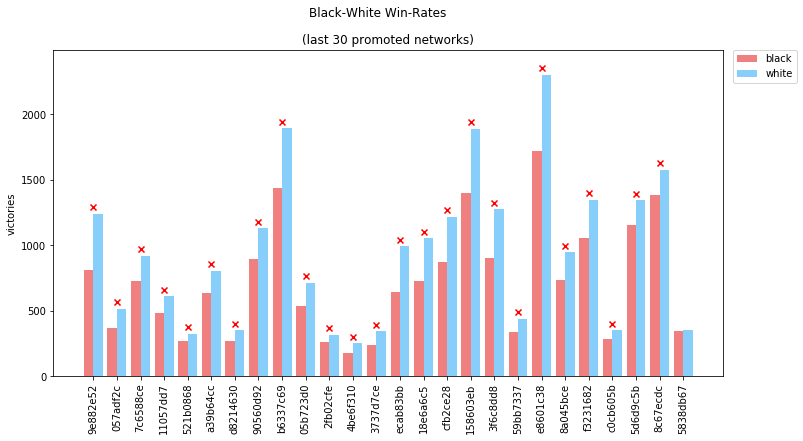


Data from 25 of 26 networks proved sufficient to reject the null hypothesis at α = 0.01.


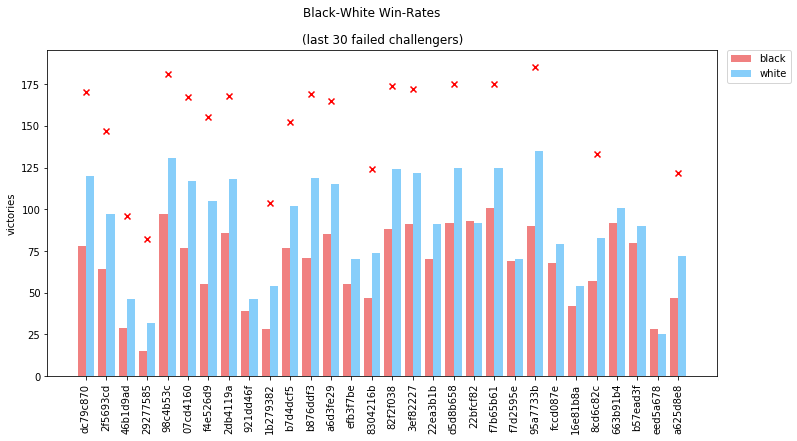


Data from 20 of 30 networks proved sufficient to reject the null hypothesis at α = 0.01.


In [11]:
query = """
SELECT Network.id, Network.upload_date,
 SUM(case when Network.id = Game.black then 1 else 0 end) as black_games,
 SUM(case when victor = 1 and Network.id = Game.black then 1 else 0 end) as black_victories,
 SUM(case when Network.id = Game.white then 1 else 0 end) as white_games,
 SUM(case when victor = 2 and Network.id = Game.white then 1 else 0 end) as white_victories
 FROM Network
 JOIN Game on Game.black = Network.id OR Game.white = Network.id
 WHERE Network.promoted={0}
 GROUP BY Network.id
 ORDER BY Network.upload_date DESC
"""

present_network_black_white_win_rate(query.format(1), '(last {0} promoted networks)')
present_network_black_white_win_rate(query.format(0), '(last {0} failed challengers)')

### Fairness Tests: Self-Play Games

In [ ]:
def present_self_play_black_white_win_rate(query, title, history = 30):
    data_count = 0
    data_black_victories = []
    data_white_victories = []
    data_ticks = []
    data_rejects = []
    total_black_victories = 0
    total_white_victories = 0

    with sqlite3.connect(db_path) as sql:
        cursor = sql.execute(query + " LIMIT ?", [history])

        for r in cursor:
            (id, upload_date, black_victories, white_victories) = r
            total_black_victories += black_victories
            total_white_victories += white_victories

            reject = test_fairness((black_victories + white_victories), 0.5, black_victories, alpha, silent=True)

            data_count = data_count + 1
            data_black_victories.append(black_victories)
            data_white_victories.append(white_victories)
            data_ticks.append(id[0:8])
            data_rejects.append((max(black_victories, white_victories) + 400) if reject else None)

    print("Black won {0} games; white won {1}.".format(total_black_victories, total_white_victories))
    print()

    test_fairness((total_black_victories + total_white_victories), 0.5, total_black_victories, alpha)

    pyplot.figure()
    pyplot.pie([total_black_victories, total_white_victories],
               labels = ['black', 'white'], colors = ['lightcoral', 'lightskyblue'], explode = (0.01, 0),
               autopct = '%1.4f%%', shadow=False, startangle=70)
    pyplot.axis('equal')
    pyplot.show()

    data_index = np.arange(data_count)

    pyplot.figure(figsize=(12, 6))
    pyplot.bar(data_index, data_black_victories, 0.4, color='lightcoral', label='black')
    pyplot.bar(data_index + 0.4, data_white_victories, 0.4, color='lightskyblue', label='white')
    pyplot.scatter(data_index + 0.2, data_rejects, marker='x', color='red')

    pyplot.suptitle('Black-White Win-Rates')
    pyplot.title(title.format(history))
    pyplot.ylabel('victories')
    pyplot.xticks(data_index + 0.2, data_ticks, rotation=90)
    pyplot.legend(bbox_to_anchor=(1.11, 1.0), loc='upper right', borderaxespad=0)
    pyplot.show()

    print()
    print("Self-Play Data from {0} of {1} networks proved sufficient to reject the null hypothesis at α = {2}.".format(sum(r is not None for r in data_rejects), len(data_rejects), alpha))

In [ ]:
query = """
SELECT
 Network.id, Network.upload_date,
 black_victories,
 white_victories
 FROM SelfPlay
 JOIN Network on Network.id = SelfPlay.network_id
 GROUP BY SelfPlay.network_id
 ORDER BY upload_date DESC
"""
present_self_play_black_white_win_rate(query.format(1), '(self-play games)', history=5)

## Data Sources

### Fetch Web Data

Scrape http://zero.sjeng.org/ for data from Leela Zero's training matches and store that data in a Sqlite database that can be queried offline.

In [ ]:
web.fetch_database(db_path)

In [ ]:
(networks, matches) = web.fetch_index()
print("Listed Networks: ", len(networks))
print("Listed Matches:  ", len(matches))

match = matches['5b07ca55888bab42e3cde074']
if (None == match):
    print("Match not found!")
else:
    print("Match: ", match['id'])
    games = web.fetch_match_index(match)
    print("Games: ", len(games))
    print(games)

### Import Self-Training SGF Data

In [ ]:
sgf_path = r"~ ~ ~/all.sgf"

def report_progress(imported, failed, ignored):
    display.clear_output(wait = True)
    print('{0} self-play game records imported. ({1} failed, {2} ignored)'.format(imported, failed, ignored))
    
sgf.import_self_plays(db_path, sgf_path, report_progress)